<a href="https://colab.research.google.com/github/mysoniw/tensor-flow/blob/master/03_Bayse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br></br>
# **나이브베이즈 한글 적용**
nltk를 활용한 네이버 영화리뷰 평가모델 [nltk book](https://www.nltk.org/book/ch06.html) | [nltk How to](http://www.nltk.org/howto/classify.html)
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [2]:
! cat ./ratings_test.txt | head -n 10

id	document	label
6270596	굳 ㅋ	1
9274899	GDNTOPCLASSINTHECLUB	0
8544678	뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아	0
6825595	지루하지는 않은데 완전 막장임... 돈주고 보기에는....	0
6723715	3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??	0
7898805	음악이 주가 된, 최고의 음악영화	1
6315043	진정한 쓰레기	0
6097171	마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다	0
8932678	갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다	0


In [0]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/20)) ]
    return random_data

In [4]:
train_data = read_data('./ratings_train.txt')
test_data  = read_data('./ratings_test.txt')

print('Train_data ({})\nsample : {}\nTest_data  ({})\nsample : {}'.format(
    len(train_data), train_data[:3],
    len(test_data),  test_data[:3]))

Train_data (7500)
sample : [['2605495', '그만하자', '0'], ['3378306', '살면서 가장재미없는영화 진심으로', '0'], ['9793706', '잼따 ㅎㅎ신선하고 특이하게 웃기다 ㅎㅎㅎ', '1']]
Test_data  (2500)
sample : [['9454303', '재미는 없네요... 기대를 하고 봐서 그런가', '0'], ['4914817', '오리지날을 한번더 보는게 백배는 나은선택', '0'], ['9392812', '딱 일본영화 스타일 너무 잔잔합니다', '0']]


In [5]:
%%time
from konlpy.tag import Okt
twitter = Okt()

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


[(['그만하다/Adjective'], '0'),
 (['살다/Verb', '가장/Noun', '재미없다/Adjective', '영화/Noun', '진심/Noun', '으로/Josa'],
  '0')]
CPU times: user 1min 18s, sys: 787 ms, total: 1min 18s
Wall time: 1min


In [6]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:50]))

Token Total :107626
Sample : ['그만하다/Adjective', '살다/Verb', '가장/Noun', '재미없다/Adjective', '영화/Noun', '진심/Noun', '으로/Josa', '잼/Noun', '따다/Verb', 'ㅎㅎ/KoreanParticle', '신선하다/Adjective', '특이하다/Adjective', '웃기/Noun', '다/Josa', 'ㅎㅎㅎ/KoreanParticle', '크다/Verb', '기대다/Verb', '안/VerbPrefix', '하다/Verb', '반짝/Noun', '주목/Noun', '하다/Verb', '소재/Noun', '에/Josa', '너무/Adverb', '흥미/Noun', '없다/Adjective', '스토리/Noun', './Punctuation', '결말/Noun', '은/Josa', '더/Noun', '더욱/Noun', '영/Noun', '../Punctuation', '투자자/Noun', '와/Josa', '제작자/Noun', '들/Suffix', '을/Josa', '말리/Noun', '고/Josa', '싶다/Verb', '심정/Noun', './Punctuation', '난/Noun', '영화/Noun', '보다/Verb', '설레다/Adjective', '모/Noun']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [7]:
import nltk
text = nltk.Text(tokens, name='네이버리뷰')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common( 5 ))    

number of Token : 107626 
unique Token    : 11259

[('./Punctuation', 3509),
 ('영화/Noun', 2568),
 ('하다/Verb', 2054),
 ('이/Josa', 2007),
 ('보다/Verb', 1950)]


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumGothic', 'Malgun Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


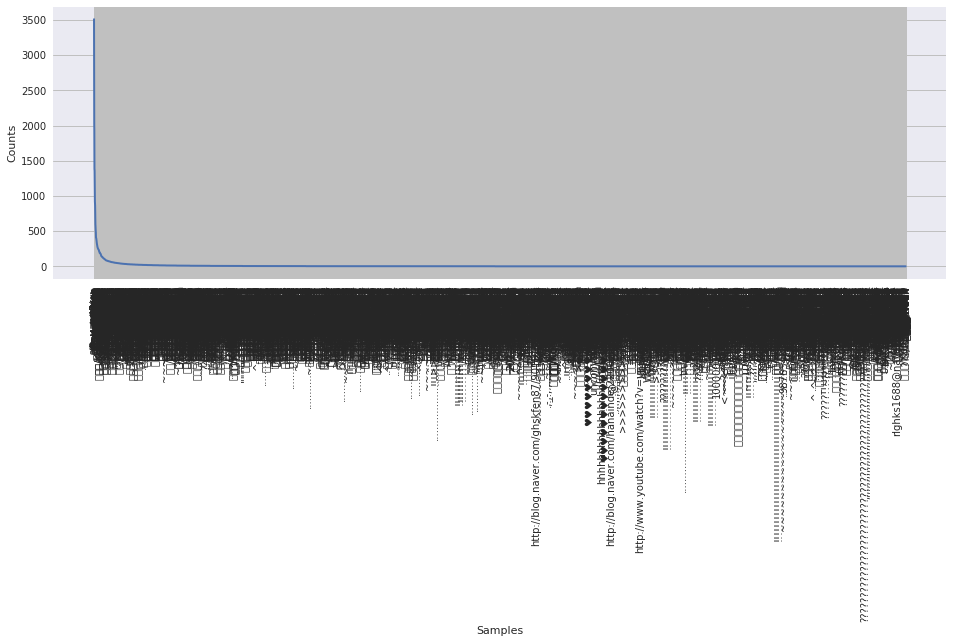

In [8]:
%matplotlib inline
from matplotlib import rc
rc('font', family=['NanumGothic','Malgun Gothic'])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot() 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [9]:
# 검색가능 단어목록 추출하기
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '이/Josa', '보다/Verb']

In [0]:
# Mission 1
# selected 객체를 './data/selected.words' 로 저장하기
import pickle
pickle.dump(selected_words, open('./selected.words', 'wb'))

In [11]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 45.5 s, sys: 3.24 s, total: 48.8 s
Wall time: 48.7 s


In [12]:
# 문장별 Text을 분석가능한 Token으로 변환
line_num = 130
print("100th 문장 변환된 Token 갯수 : {}\n\nSample : {}".format(
    len(train_xy[line_num][0]),
    train_xy[line_num][0]))

100th 문장 변환된 Token 갯수 : 4000

Sample : {'exists(./Punctuation)': False, 'exists(영화/Noun)': True, 'exists(하다/Verb)': False, 'exists(이/Josa)': False, 'exists(보다/Verb)': True, 'exists(의/Josa)': False, 'exists(가/Josa)': False, 'exists(../Punctuation)': False, 'exists(에/Josa)': False, 'exists(을/Josa)': False, 'exists(.../Punctuation)': False, 'exists(도/Josa)': False, 'exists(은/Josa)': False, 'exists(들/Suffix)': False, 'exists(,/Punctuation)': False, 'exists(는/Josa)': False, 'exists(를/Josa)': False, 'exists(없다/Adjective)': True, 'exists(좋다/Adjective)': False, 'exists(너무/Adverb)': False, 'exists(있다/Adjective)': False, 'exists(이/Determiner)': False, 'exists(정말/Noun)': False, 'exists(?/Punctuation)': False, 'exists(것/Noun)': False, 'exists(재밌다/Adjective)': False, 'exists(되다/Verb)': False, 'exists(으로/Josa)': False, 'exists(!/Punctuation)': False, 'exists(아니다/Adjective)': False, 'exists(점/Noun)': False, 'exists(같다/Adjective)': False, 'exists(않다/Verb)': False, 'exists(진짜/Noun)': False, 'exists(이/N

In [13]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 1min 2s, sys: 50.1 ms, total: 1min 2s
Wall time: 1min 2s


In [0]:
# Mission 2
# classifiers 객체를 './classifiers.model' 로 저장하기
import pickle
pickle.dump(classifiers, open('./classifiers.model', 'wb'))

<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [15]:
%%time
import pickle
# 학습한 모델객체 저장하기
# Google 에 찾아보기 : Python classifier Save

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.6 µs


In [16]:
classifiers.labels()

['0', '1']

In [17]:
classifiers.show_most_informative_features(20)

Most Informative Features
         exists(최악/Noun) = True                0 : 1      =     41.4 : 1.0
         exists(점도/Noun) = True                0 : 1      =     30.1 : 1.0
        exists(최고다/Noun) = True                1 : 0      =     24.6 : 1.0
  exists(재미없다/Adjective) = True                0 : 1      =     23.3 : 1.0
         exists(노잼/Noun) = True                0 : 1      =     20.1 : 1.0
         exists(짜증/Noun) = True                0 : 1      =     20.1 : 1.0
         exists(졸작/Noun) = True                0 : 1      =     16.2 : 1.0
   exists(슬프다/Adjective) = True                1 : 0      =     14.8 : 1.0
  exists(따뜻하다/Adjective) = True                1 : 0      =     14.7 : 1.0
        exists(쓰레기/Noun) = True                0 : 1      =     14.7 : 1.0
         exists(실망/Noun) = True                0 : 1      =     13.7 : 1.0
         exists(가슴/Noun) = True                1 : 0      =     13.6 : 1.0
  exists(어설프다/Adjective) = True                0 : 1      =     13.3 : 1.0

In [18]:
%%time
# Test 데이터로 Model의 정확도 측정
'네이버 영화리뷰 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 37.2 s, sys: 33.1 ms, total: 37.2 s
Wall time: 37.2 s


'네이버 영화리뷰 모델의 Accuracy : 0.8036'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [0]:
review = """졸잼 굿 최고입니다 최고"""

In [20]:
# 리뷰 데이터를 Tagged Token 생성하기
review = tokenize(review)    
review

['졸잼/Noun', '굿/Noun', '최고/Noun', '이다/Adjective', '최고/Noun']

In [21]:
# Tagged Token 중 selected_words 포함여부 판단
review = term_exists(review) 
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(최고/Noun) = True
exists(이다/Adjective) = True
exists(굿/Noun) = True
exists(졸잼/Noun) = True


In [22]:
result = classifiers.classify(review)  # 분류모델 평가
if result == '1': 
    print('긍정리뷰')
else:             
    print('부정리뷰')

긍정리뷰
